In [1]:
using Pkg
Pkg.activate(".")
using QuadGK, Plots, Roots

  Activating project at `c:\Users\Liam\Documents\PhD\Research\Scripts\StochasticSimulations`


In [3]:
# All parameter values are from the papers: Sauter et al. 1989, Sauter et al. 1992

# In SI units
# kB = 1.380649e-23 # J/K = m^2⋅kg/(s^2⋅K)
# T = 297           # K
# σ = 1e-10         # m
# KD = 1.4-6.5e-3   # Molar = mol/m^3
# r0 = σ*(2/(kB*T) * ( 3*ϵ + sqrt(9*ϵ^2-6*kB*T*ϵ) ))^(1/6)

# [Protein] = Protein Concentration, I think. I am assuming that proteins and ligands are in equal concentration.
# Sauter 1989, first row of table 1: [protein] = 33μM = 3.3e-8 mol/m^3 = 3.3e-35 mol/nm^3
# So then [protein] = 1.9873064508e-11 N/nm^3 where N = Number of proteins
# Therefore the effective volume occupied by a pair is V = 1/[protein] = 1.9873064508e11 nm^3
# Note that when [protein] = KD, we should expect a probability of being bound = 1/2 (confirmed)

# Convert to nm
kB = 1.380649e-5               # nm^2⋅kg/(s^2⋅K)
T = 297                        # K
σ = 1.5e-1                     # nm
KD = 2.8e-30 * 6.02214076e23   # N/nm^3
ρ = 1.9873064508e-11           # N/nm^3
V = 1.9873064508e11            # nm^3
R = cbrt(3*V/(4*pi))           # nm
println("Effective radius of space = $R nm")

VLJ(r,ϵ) = 4*ϵ*((σ/r)^12 - (σ/r)^6)
ExpTerm(r,ϵ) = exp(-VLJ(r,ϵ)/(kB*T))
f(r,ϵ) = r^2 * ExpTerm(r,ϵ)
Bound(ϵ) = σ*(2/(kB*T) * ( 3*ϵ[1] + sqrt(9*ϵ[1]^2-6*kB*T*ϵ[1]) ))^(1/6)
BoundDeriv(ϵ) = σ/6*(2/(kB*T))^(1/6) * ( 3*ϵ[1] + sqrt(9*ϵ[1]^2-6*kB*T*ϵ[1]) )^(-5/6) *
                ( 3 + 1/2*(9*ϵ^2-kB*T*ϵ)^(-1/2) * (18*ϵ-kB*T) )
;

Effective radius of space = 3620.140373932604 nm


In [4]:
function BoltzIntegral(ϵ,a,b)
    integral, error = quadgk(r -> f(r,ϵ), a, b, rtol=1e-8)
    return integral, error
end

function ratio(ϵ,p)
    r0 = Bound(ϵ[1])
    int1, err1 = quadgk(r -> f(r,ϵ[1]), 0, r0, rtol=1e-8)
    int2, err2 = quadgk(r -> f(r,ϵ[1]), 0, R, rtol=1e-8)
    rat = int1/int2
    return rat - 1/(1+KD*V)
end

function OptFunc(ϵ)
    r0 = Bound(ϵ)
    int1, err1 = quadgk(r -> f(r,ϵ), 0, r0, rtol=1e-8)
    int2, err2 = quadgk(r -> f(r,ϵ), 0, R, rtol=1e-8)
    return int2 - (1+KD*V)*int1
end

function OptFuncDeriv(ϵ)
    r0 = Bound(ϵ)
    IntInf, ErrInf = quadgk(r -> VLJ(r,ϵ)*f(r,ϵ), 0, r0, rtol=1e-8)
    IntR0, ErrR0 = quadgk(r -> VLJ(r,ϵ)*f(r,ϵ), 0, 1e8, rtol=1e-8)
    return -1/(ϵ*kB*T)*IntInf - (1+KD) * (1/r0^2*ExpTerm(r0,ϵ)*BoundDeriv(ϵ) - 1/(ϵ*kB*T)*IntR0)
end
;
# func = OptimizationFunction(OptFunc, grad = OptFuncDeriv)
# prob = OptimizationProblem(func, [1.0])# , lb=[2/3*kB*T], ub=[Inf])
# sol = solve(prob, SimulatedAnnealing())

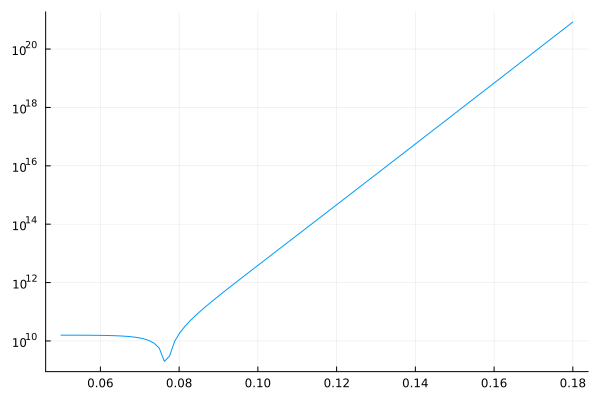

In [5]:
# Find the range in which the zero-point exists for the optimising function
let
    AbsFunc(ϵ) = abs(OptFunc(ϵ))
    plot(range(0.05,0.18,length=100), AbsFunc, yaxis=:log, legend=:none)
end

In [6]:
# Initial guess comes from figure in the previous cell
# 0.07682985072677195
ZeroPoint = find_zero(OptFunc, (0.01,1)) # (2/3*kB*T,R))
println("ϵ = $ZeroPoint")
# Check the solution:
let 
    r0 = Bound(ZeroPoint)
    int1, err1 = quadgk(r -> f(r,ZeroPoint), 0, r0, rtol=1e-8)
    int2, err2 = quadgk(r -> f(r,ZeroPoint), 0, R, rtol=1e-8)
    Error = int1/int2 - 1/(1+KD*V)
    println("Error in answer = $Error")
end

ϵ = 0.07682985072677195
Error in answer = -3.8116482626443515e-21


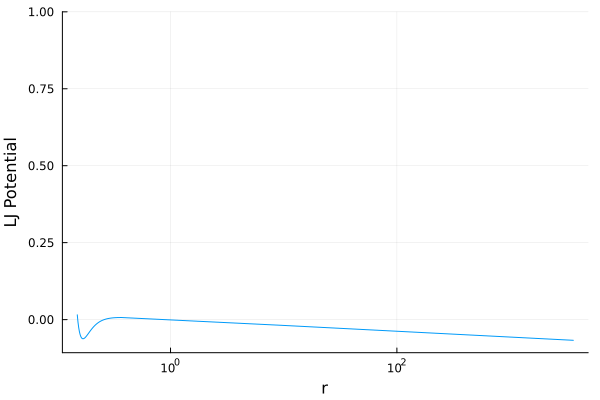

In [7]:
# Visualise the depth of the well from the minimum of the well
let 
    r0 = Bound(ZeroPoint)
    RPlot = append!( collect(range(σ,r0,length=100)) , collect(range(r0,R,length=400)) )
    plot(RPlot, r -> VLJ(r,ZeroPoint)-2*kB*T*log(r),
    xlabel="r", ylabel="LJ Potential",
    ylims=(-ZeroPoint*1.4, 1),
    xaxis=:log,
    legend = :none)
end

Probability of being bound = 2.9841793994200975e-6


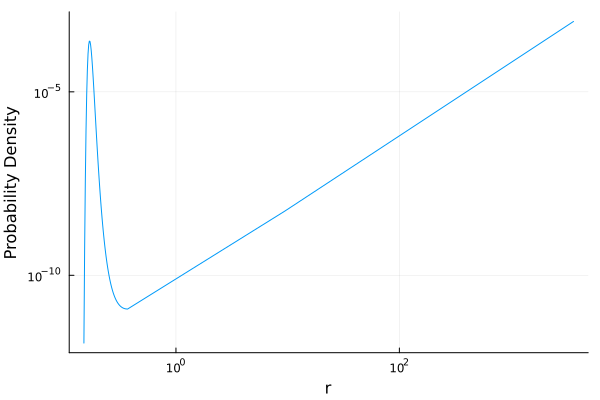

In [9]:
# Visualise the probability density from the maximum of the probability peak
let 
    r0 = Bound(ZeroPoint)
    RPlot = append!( collect(range(σ,r0,length=100)) , collect(range(r0,R,length=400)) )
    K1 = 1/(quadgk(r -> f(r,ZeroPoint), 0, R, rtol=1e-8)[1])
    ProbBound = quadgk(r -> K1*f(r,ZeroPoint), 0, r0, rtol=1e-8)[1]
    println("Probability of being bound = $ProbBound")

    plot(RPlot, r -> K1*f(r,ZeroPoint), 
    legend=:none, 
    xlabel="r", ylabel="Probability Density",
    xaxis=:log, yaxis=:log)
end